<a href="https://colab.research.google.com/github/SiyueZhang41/forest_management/blob/main/processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd # for dataset manipulation
import numpy as np # for numerical operations
from scipy import stats # for statistical functions
import geopandas as gpd # for geospatial data handling
import matplotlib.pyplot as plt # for plotting
from shapely.geometry import Point # for handling lattitude and longitude coordinates
import datetime # for date and time manipulation

import warnings
warnings.filterwarnings('ignore') # ignore warnings for clarity

## Question 1: Kruskal-Wallis test between managed and natural forest

In [ ]:
file_path = "./sample_data/file_task_PhDVacancyUAntwerp_May2025.xlsx"

df_sheet1 = pd.read_excel(file_path, sheet_name='annual_production', engine='openpyxl') # Reading the Excel file and loading the 'annual_production' sheet into a DataFrame

# Initial inspection of the DataFrame
# df_sheet1.shape
# df_sheet1.dtypes
# df_sheet1.head()
# df_sheet1.info() # Used to check the structure and data types of the DataFrame

Forest_df_sheet1 = df_sheet1[(df_sheet1['BIOME_TYPE'] == 'F')] # Filtering the DataFrame for forest biomes only
# Forest_df_sheet1.shape
# Forest_df_sheet1.dtypes
# Forest_df_sheet1.head()
print('Inspection of the annnual production data for forest biomes:')
Forest_df_sheet1.info()

Inspection of the annnual production data for forest biomes:
<class 'pandas.core.frame.DataFrame'>
Index: 166 entries, 161 to 397
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SITE_NUMBER         166 non-null    int64  
 1   LATITUDE            166 non-null    float64
 2   LONGITUDE           166 non-null    float64
 3   ANPP                160 non-null    float64
 4   BIOME_TYPE          166 non-null    object 
 5   MANAGEMENT          166 non-null    object 
 6   ANNUAL_TEMPERATURE  166 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 10.4+ KB


Noticed 6 missing values in the ANPP column.

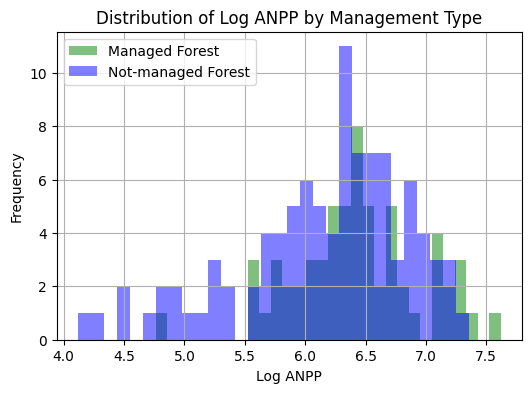

 Number of managed forests: 62
 Number of not-managed forests: 98
KruskalResult: stat = 3.8058178190129865, P-value = 0.051074828031968424


In [ ]:

filter_nan = (Forest_df_sheet1['ANPP'].notna()) & (Forest_df_sheet1['ANPP'] > 0) # Filter the DataFrame to include only rows where 'ANPP' is not NaN and greater than 0
df_for_kw = Forest_df_sheet1[filter_nan]
df_for_kw['logANPP'] = np.log(df_for_kw['ANPP']) # Transform ANPP value as log(ANPP) to reduce skewness

M_group = df_for_kw[df_for_kw['MANAGEMENT'] == 'M']['logANPP']
N_group = df_for_kw[df_for_kw['MANAGEMENT'] == 'N']['logANPP'] # Extract log ANPP values for managed and not-managed forests

plt.figure(figsize=(6, 4))
plt.hist(M_group, bins=30, alpha=0.5, label='Managed Forest', color='green')
plt.hist(N_group, bins=30, alpha=0.5, label='Not-managed Forest', color='blue')
plt.xlabel('Log ANPP')
plt.ylabel('Frequency')
plt.title('Distribution of Log ANPP by Management Type')
plt.legend()
plt.grid(True)
plt.show() # Check the distribution of log ANPP values for managed and not-managed forests

print(f' Number of managed forests:', M_group.count())
print(f' Number of not-managed forests:', N_group.count()) # Count the number of managed and not-managed forests

stat, p = stats.kruskal(M_group, N_group)
print(f"KruskalResult: stat = {stat}, P-value = {p}") # Perform the Kruskal-Wallis test to compare the distributions of log ANPP values between managed and not-managed forests

## Question 2: Map of European forest sites

Managed forest: 30; Not-managed forest: 10


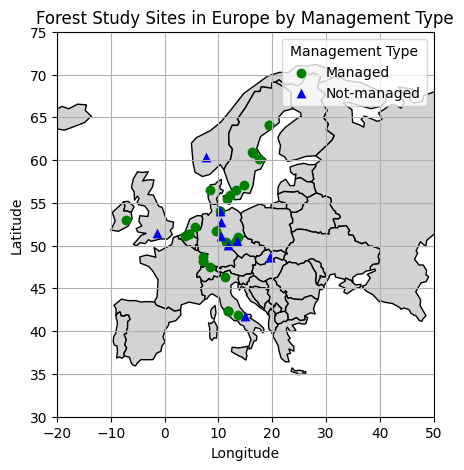

In [ ]:
world_map = gpd.read_file("./sample_data/ne_110m_admin_0_countries.zip").to_crs(epsg=4326) # Read the world map shapefile and convert it to the WGS 84 coordinate reference system (EPSG:4326)
filter_Europe = world_map['CONTINENT'] == 'Europe'
Europe_map = world_map[filter_Europe] # Clip the world map to include only European countries


points = [Point(xy) for xy in zip(Forest_df_sheet1['LONGITUDE'], Forest_df_sheet1['LATITUDE'])] # Create a list of Point geometries from the longitude and latitude columns in the DataFrame
gdf_sheet1 = gpd.GeoDataFrame(Forest_df_sheet1, geometry = points, crs="EPSG:4326") # Convert the DataFrame to a GeoDataFrame

polygon_Europe = Europe_map.unary_union # Transform the European map into a polygon
def is_in_Europe(x):
    return(x.within(Europe_map.unary_union)) # Check if a longitude/latitude point is in Europe

gdf_sheet1['is_in_europe'] = gdf_sheet1.geometry.apply(is_in_Europe) # Check if each point is in European continent

points_in_europe = gdf_sheet1[gdf_sheet1['is_in_europe'] == True] # Filter the GeoDataFrame to include only points that are within Europe

count_managed = (points_in_europe['MANAGEMENT'] == 'M').sum()
count_natural = (points_in_europe['MANAGEMENT'] == 'N').sum() # Count the number of managed and not-managed forests within Europe

print(f"Managed forest: {count_managed}; Not-managed forest: {count_natural}")

fig, ax = plt.subplots(figsize=(5, 5))
Europe_map.plot(ax=ax, color='lightgray', edgecolor='black') # Plot the European map


styles = {
    'M': {'color': 'green', 'marker': 'o', 'label': 'Managed'},
    'N': {'color': 'blue', 'marker': '^', 'label': 'Not-managed'}
} # Define styles for different management types

for mgmt, style in styles.items():
    subset = points_in_europe[points_in_europe['MANAGEMENT'] == mgmt]
    subset.plot(ax=ax,
                color=style['color'],
                marker=style['marker'],
                markersize=50,
                label=style['label'],
                linewidth=0) # Plot the points on the map with different styles based on management type


plt.legend(title="Management Type", loc='best')
plt.title('Forest Study Sites in Europe by Management Type')
plt.xlabel('Longitude')
plt.xlim(-20, 50)
plt.ylabel('Latitude')
plt.ylim(30, 75)
plt.grid(True)
plt.show()

### Question 3: GDD and Budburst day in 2018 and 2019

In [ ]:
df_sheet2 = pd.read_excel(file_path, sheet_name='budburst', engine='openpyxl') # Read the 'budburst' sheet into a DataFrame


def date_to_doy(date):
    month_day = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    doy = sum(month_day[:date.month - 1]) + date.day
    return doy # Function to convert a date to its day of the year (DOY)

date_2018 = datetime.datetime(2018, 4, 16) # Define reference date: April 16, 2018
doy_2018 = date_to_doy(date_2018) # Convert the reference date to DOY
print(f"DOY for {date_2018.strftime('%Y-%m-%d')} is {doy_2018}")

df_sheet2 = df_sheet2.T # Transpose the DataFrame to have DOY as index and years as columns

GDD_2018 = 0
threshold_temp = 5
for i in range(2, doy_2018 + 2):
    temp_2018 = df_sheet2.iloc[i, 0]
    if temp_2018 > threshold_temp:
        GDD_2018 += temp_2018 - threshold_temp # Calculate Growing Degree Days (GDD) for 2018 during DOY 1 to DOY 107
print(f"2018 GDD: {GDD_2018}")

GDD_2019 = 0
day_reached = 0
for i in range (2, 368):
    temp_2019 = df_sheet2.iloc[i, 1]
    if GDD_2019 < GDD_2018 and temp_2019 > threshold_temp:
        GDD_2019 += temp_2019 - threshold_temp
        day_reached = df_sheet2.index[i] # Calculate GDD for 2019 until it reaches the same GDD as in 2018
print(f"2019 GDD: {GDD_2019}, DOY of budburst 2019: {day_reached}")

doy_number = int(day_reached.replace('DOY',''))
def doy_to_date(year, doy_number):
    return datetime.datetime(year, 1, 1) + datetime.timedelta(days=doy_number - 1) # Convert DOY to date

date_2019 = doy_to_date(2019, doy_number)
print(f"Budburst date in 2019: {date_2019.strftime('%Y-%m-%d')}")


DOY for 2018-04-16 is 107
2018 GDD: 213.21998785808685
2019 GDD: 214.42998760752386, DOY of budburst 2019: DOY89
Budburst date in 2019: 2019-03-30


## A graph that shows the GDD in both years from January 1st onwards

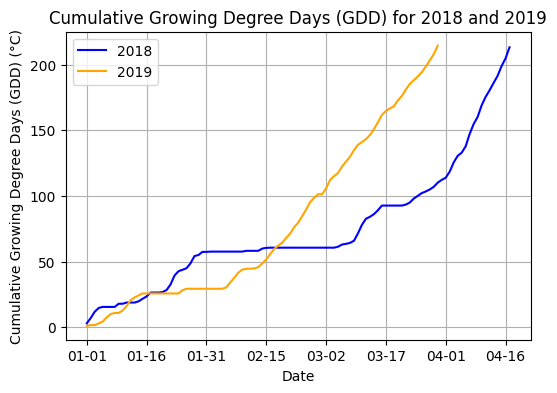

In [ ]:
GDD_2018_cum = []
GDD_2019_cum = [] # Create lists to store cumulative GDD for 2018 and 2019

GDD_2018 = 0
GDD_2019 = 0

for i in range(2, doy_2018 + 2):
    temp_2018 = df_sheet2.iloc[i, 0]
    if temp_2018 > threshold_temp:
        GDD_2018 += temp_2018 - threshold_temp
    GDD_2018_cum.append(GDD_2018) # Calculate cumulative GDD for 2018

for i in range(2, doy_number + 2):
    temp_2019 = df_sheet2.iloc[i, 1]
    if temp_2019 > threshold_temp:
        GDD_2019 += temp_2019 - threshold_temp
    GDD_2019_cum.append(GDD_2019) # Calculate cumulative GDD for 2019

days_of_2018 = list(range(1, doy_2018 + 1))
days_of_2019 = list(range(1, doy_number + 1)) # Create x-axis values for plotting

plt.figure(figsize=(6, 4))
plt.plot(days_of_2018, GDD_2018_cum, label='2018', color='blue')
plt.plot(days_of_2019, GDD_2019_cum, label='2019', color='orange')

plt.xlabel('Date')
plt.ylabel('Cumulative Growing Degree Days (GDD) (°C)')
plt.xticks([ii for ii in days_of_2018[::15]], [doy_to_date(2018, ii).strftime('%m-%d')for ii in days_of_2018[::15]]) # Set x-axis ticks to show every 15th day as date
plt.title('Cumulative Growing Degree Days (GDD) for 2018 and 2019')
plt.legend()
plt.grid(True)
plt.show()